# Processing Mirage22 Data
The data has been converted from the provided JSON to a csv with the headers
`five-tuple,timestamp,iat,packet_size`

1. Seperate the IP flows
2. Use inter-arrival time to verify data integrity

In [2]:
import pandas as pd
pcap_df = pd.read_csv(r"data\discord_data\4.csv")

### Seperating IP Flows

In [6]:
def seperate_flows(pcap_df):
    return dict(tuple(pcap_df.groupby('five-tuple')))

### Verify Data Integrity

In [7]:
flows = seperate_flows(pcap_df)
print("total flows: ", len(flows))
flow_stats = []
for flow_key in flows.keys():
    flow = flows[flow_key]
    length = flow.shape[0]
    start = flow.timestamp.min()
    end = flow.timestamp.max()
    total_time = end - start
    iat_sum = flow['iat'].sum()
    md_pkt_sz = flow['packet_size'].median()
    flow_stats.append([flow_key, length, start, end, total_time, iat_sum, md_pkt_sz])

flow_stats_df = pd.DataFrame(flow_stats, columns=['five-tuple', 'size', 'start', 'end', 'total_time', 'iat_sum', 'md_pkt_sz'])

total flows:  100


In [8]:
flow_stats_df

,five-tuple,size,start,end,total_time,iat_sum,md_pkt_sz
0,"192.168.20.100,33944,213.163.87.21,50013,17",6278,1.626089e+09,1.626089e+09,60.127518,60.127518,222.0
1,"192.168.20.100,34334,213.163.87.19,50020,17",4724,1.626089e+09,1.626089e+09,60.055098,60.055098,886.0
2,"192.168.20.100,34985,213.163.87.21,50013,17",4978,1.626089e+09,1.626089e+09,60.087313,60.087313,223.0
3,"192.168.20.100,35645,162.159.128.233,443,6",132,1.626090e+09,1.626090e+09,82.562042,82.562042,46.0
4,"192.168.20.100,36295,213.163.87.21,50013,17",4228,1.626088e+09,1.626088e+09,60.102730,60.102730,219.0
...,...,...,...,...,...,...,...
95,"192.168.20.100,58594,213.163.87.19,50020,17",4828,1.626088e+09,1.626088e+09,60.108926,60.108926,851.5
96,"192.168.20.100,59149,213.163.87.21,50013,17",5388,1.626088e+09,1.626088e+09,60.111611,60.111611,215.0
97,"192.168.20.100,59364,213.163.87.19,50020,17",4798,1.626088e+09,1.626089e+09,60.101181,60.101181,863.0
98,"192.168.20.100,59436,213.163.87.19,50020,17",4751,1.626089e+09,1.626089e+09,60.103589,60.103589,879.0


In [10]:
x_vals_1 = flow_stats_df['start']
x_vals_2 = flow_stats_df['end']
datas = []
for i, xs in enumerate(zip(x_vals_1, x_vals_2)):
    datas.append((xs, (i,i)))

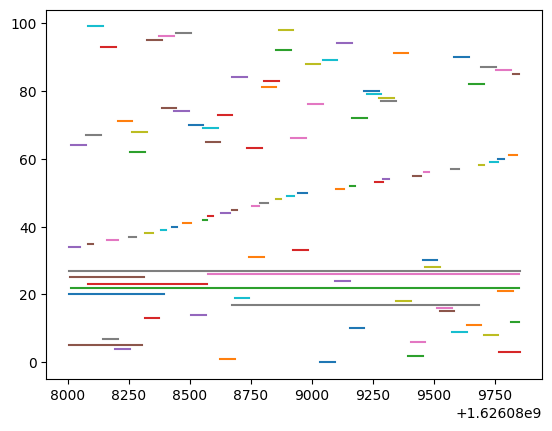

In [12]:
import matplotlib.pyplot as plt

for line in datas:
    plt.plot(line[0], line[1])

### CDF of IAT and Packet Size

In [50]:
test_flow = flows['192.168.20.104,32864,213.163.94.112,50004,17']

In [125]:
outlier_cap = test_flow['iat'].quantile(.99)
filtered_iat = test_flow[test_flow['iat'] < outlier_cap]['iat']
test_ps = test_flow['packet_size']

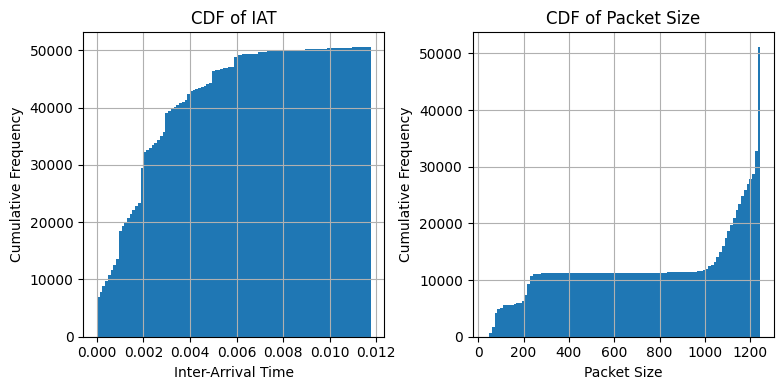

In [136]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
filtered_iat.hist(bins=100, ax=axs[0], cumulative=1)
test_ps.hist(bins=100, ax=axs[1], cumulative=1)
axs[0].set_title('CDF of IAT')
axs[0].set_xlabel('Inter-Arrival Time')
axs[0].set_ylabel('Cumulative Frequency')
axs[1].set_title('CDF of Packet Size')
axs[1].set_xlabel('Packet Size')
axs[1].set_ylabel('Cumulative Frequency')
plt.tight_layout()
plt.show()

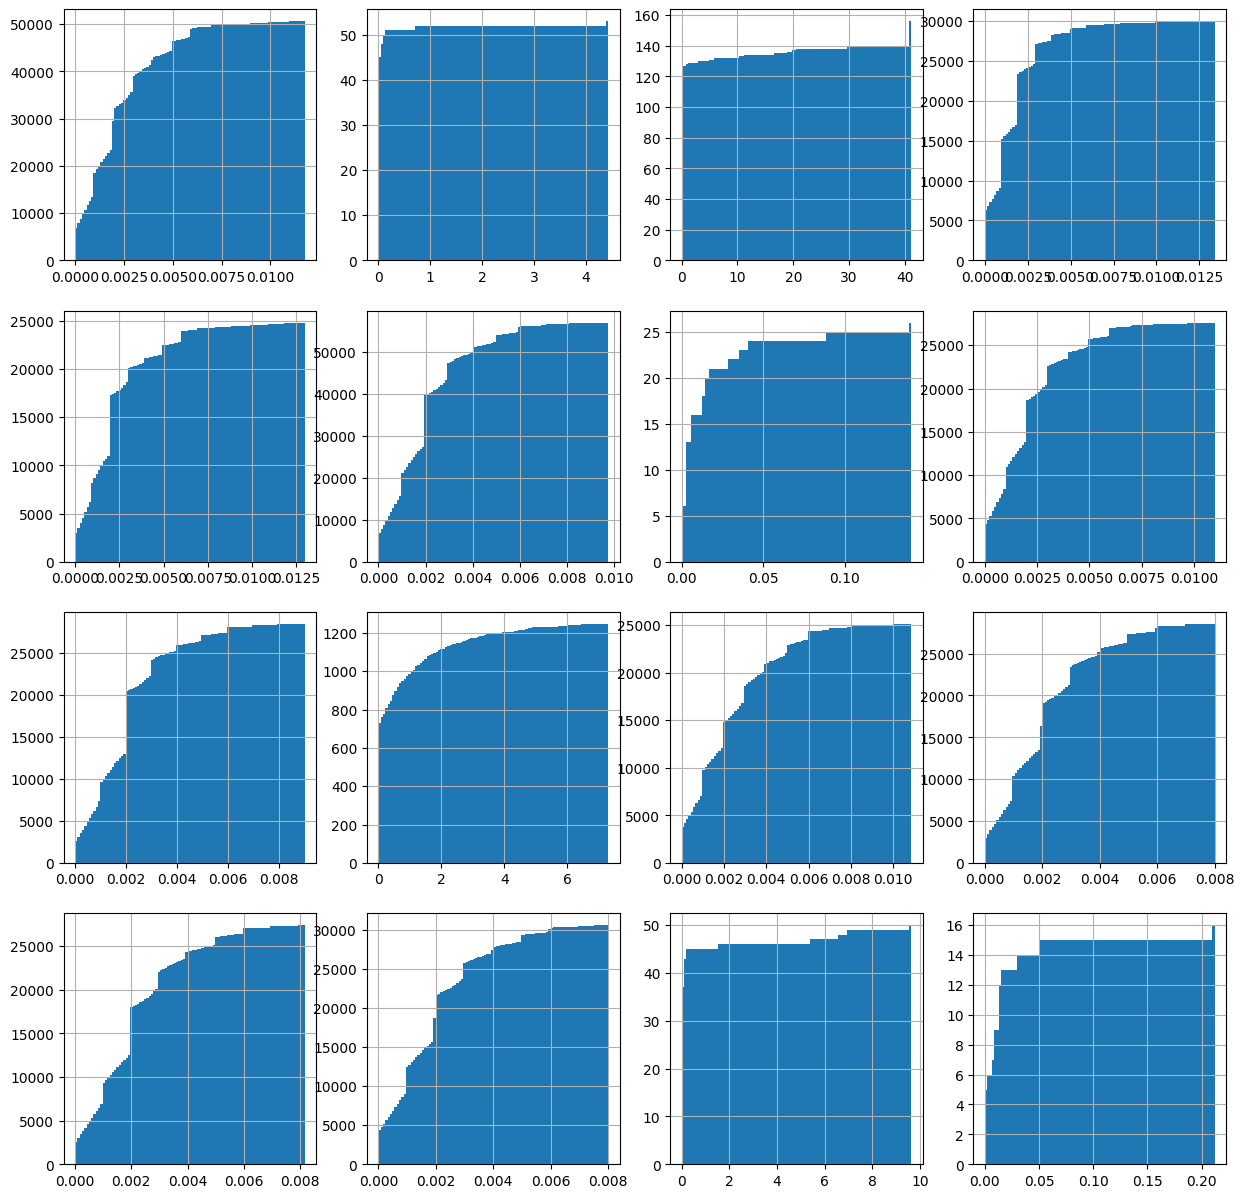

In [83]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i,flow_key in enumerate(list(flows.keys())[:16]):
    test_flow = flows[flow_key]
    outlier_cap = test_flow['iat'].quantile(.99)
    filtered_iat = test_flow[test_flow['iat'] < outlier_cap]['iat']
    row, col = divmod(i, 4)  # Calculate the row and column index
    filtered_iat.hist(bins=100,  cumulative=1, ax=axs[row, col])

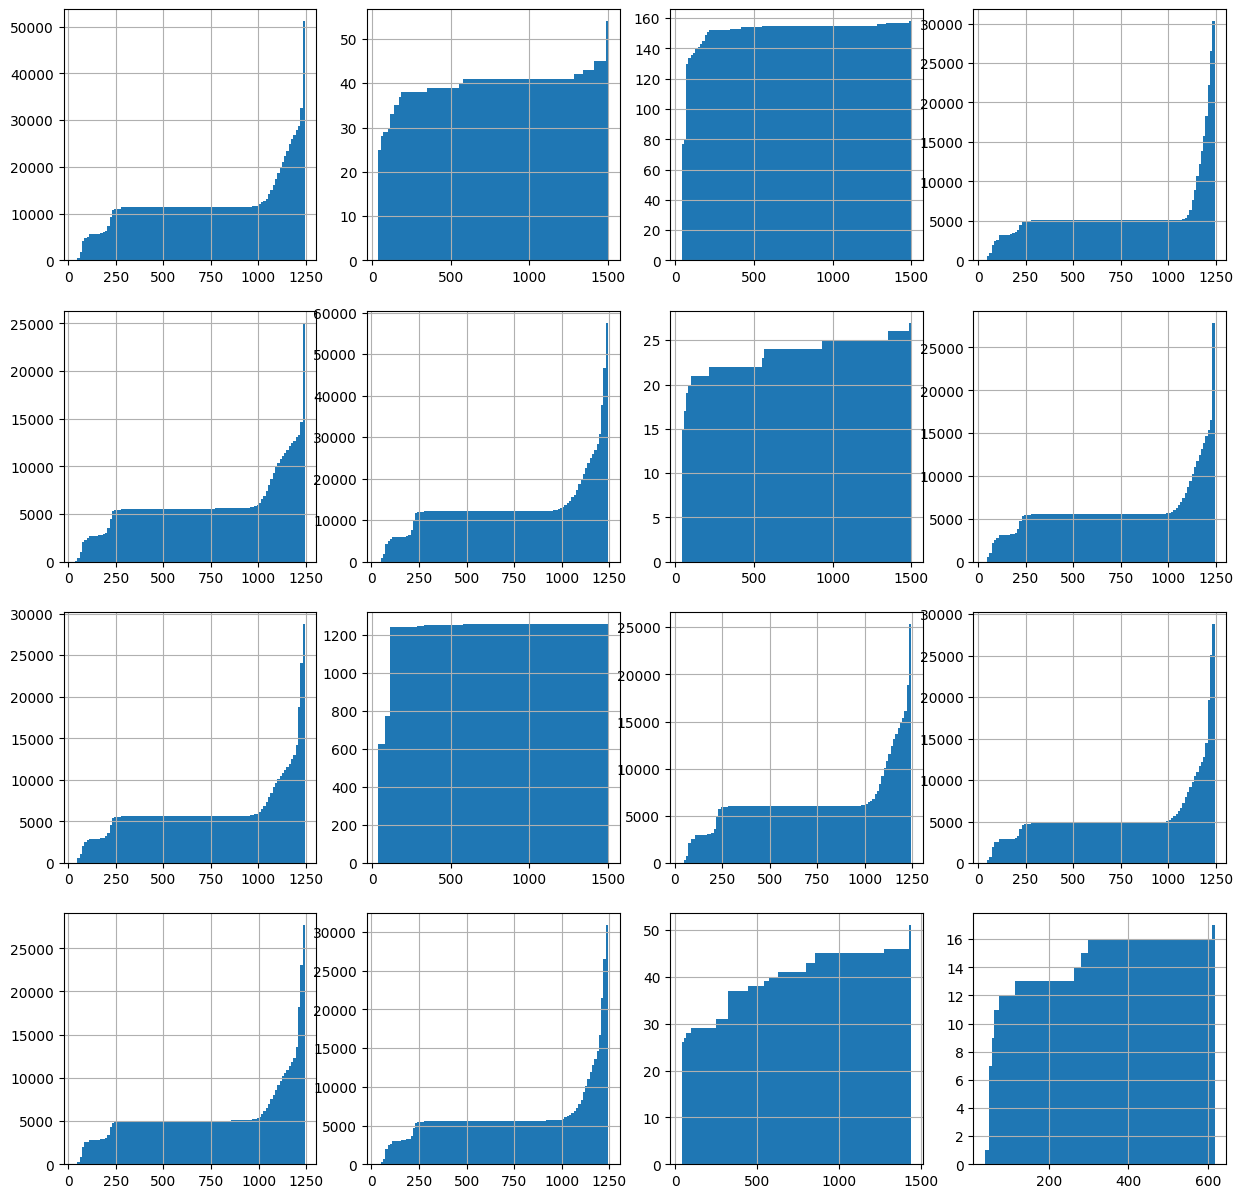

In [138]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i,flow_key in enumerate(list(flows.keys())[:16]):
    test_flow = flows[flow_key]
    row, col = divmod(i, 4)  # Calculate the row and column index
    test_flow['packet_size'].hist(bins=100,  cumulative=1, ax=axs[row, col])

In [140]:
### Converting flow to FlowPic variant

# This variant of the flowpic is closest to the one described in the original paper 10.1109/INFCOMW.2019.8845315
def create_flowpic(flow_df):

    # Filter out packets with size greater than 1500
    flow_df = flow_df[flow_df['packet_size'] <= 1500]

    # Normalize time of arrival values
    flow_df['normalized_timestamp'] = flow_df['timestamp'] - flow_df['timestamp'].min()
    # flow_df = flow_df[(flow_df['normalized_timestamp'] < 500) & (flow_df['normalized_timestamp'] > 15)]
    
    # Normalize time of arrival values to be between 0 and 1500
    max_time = 1500
    flow_df['normalized_timestamp'] = (flow_df['normalized_timestamp'] / flow_df['normalized_timestamp'].max()) * max_time

    plt.figure()
    plt.scatter(flow_df['normalized_timestamp'], flow_df['packet_size'], marker=',', c='k', s=5)

    # Plot the FlowPic
    # plt.imshow(histogram.T, origin='lower', extent=[0, max_time, 1, 1500], aspect='auto', cmap='viridis')
    plt.xlabel('Normalized Time of Arrival')
    plt.ylabel('Packet Size')
    plt.title('FlowPic')
    plt.set_cmap('binary')
    # plt.axes().set_aspect('equal')
    plt.show()

In [164]:
test_flow = flows['192.168.20.104,32864,213.163.94.112,50004,17']

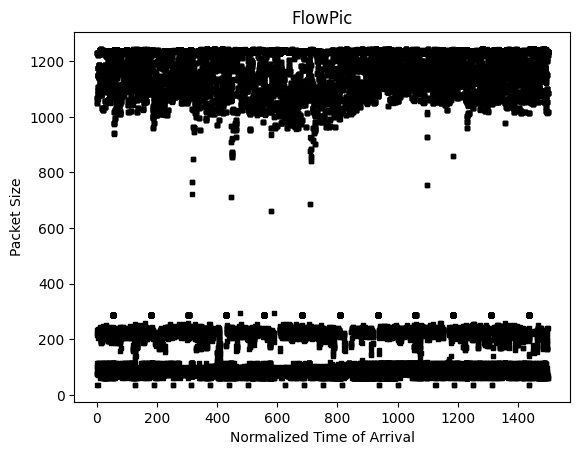

In [142]:
create_flowpic(test_flow)

Trying a different method of visualizing flow data. I will move away from the time-series component

In [143]:
def create_nathanpic(flow_df):

    # Filter out packets with size greater than 1500
    flow_df = flow_df[flow_df['packet_size'] <= 1500]


In [195]:
tflowdf = test_flow[test_flow['packet_size'] < 1500]

In [205]:
sorted_df = tflowdf.sort_values(by='timestamp').drop(columns=['five-tuple'])
sorted_df['timestamp'] = pd.to_datetime(sorted_df['timestamp'], unit='s')
df_resampled = sorted_df.set_index('timestamp').resample('50L').median()

In [206]:
# Normalize the IAT
# COME BACK TO THIS
# In the future evaluate whether normalizing is the right option

max_val = 1500
iat_outlier_cutoff = df_resampled['iat'].quantile(.999)
iat_filtered = df_resampled[df_resampled['iat'] < iat_outlier_cutoff]
iat_max = iat_filtered['iat'].max()
iat_filtered['normalized_iat'] = (iat_filtered['iat'] / iat_max) * max_val
# df_resampled = df_resampled[df_resampled['normalized_iat'] < df_resampled['normalized_iat'].quantile(.9)]

C:\Users\nathaniel\AppData\Local\Temp\ipykernel_19668\1282621510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iat_filtered['normalized_iat'] = (iat_filtered['iat'] / iat_max) * max_val


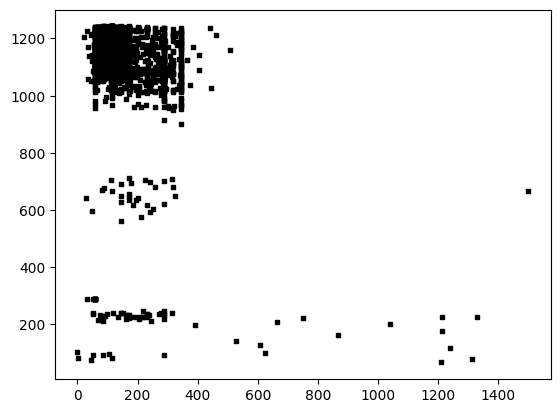

In [207]:
plt.figure()
plt.scatter(iat_filtered['normalized_iat'], iat_filtered['packet_size'], marker=',', c='k', s=5)